In [44]:
import pandas_datareader as web
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [16]:
start_date = '12-09-2010'
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()
df_three_factor.head()

,Mkt-RF,SMB,HML,RF
2010-12,0.0682,0.0069,0.0367,0.0001
2011-01,0.0199,-0.0252,0.0075,0.0001
2011-02,0.0349,0.0153,0.0136,0.0001
2011-03,0.0046,0.0259,-0.0172,0.0001
2011-04,0.0290,-0.0038,-0.0245,0.0000


In [30]:
aes = pd.read_csv('Data/aes.csv', index_col=0, parse_dates = True)
aes.head()

,aes
date,
2010-12-09,11.35
2010-12-10,11.39
2010-12-13,11.39
2010-12-14,11.31
2010-12-15,11.19


In [31]:
aes = aes['aes'].resample('M').last().pct_change().dropna()
aes.index = aes.index.strftime('%Y-%m')
aes.head()

2011-01    0.018062
2011-02   -0.002419
2011-03    0.050930
2011-04    0.018462
2011-05   -0.021148
Name: aes, dtype: float64

In [32]:
ff_data = df_three_factor.join(aes)

In [34]:
ff_data.columns = ['mkt', 'smb', 'hml', 'rf', 'aes']
ff_data['ex_rtn'] = ff_data.aes - ff_data.rf
ff_data.dropna(inplace=True)

In [35]:
ff_data.head()

,mkt,smb,hml,rf,aes,ex_rtn
2011-01,0.0199,-0.0252,0.0075,0.0001,0.018062,0.017962
2011-02,0.0349,0.0153,0.0136,0.0001,-0.002419,-0.002519
2011-03,0.0046,0.0259,-0.0172,0.0001,0.050930,0.050830
2011-04,0.0290,-0.0038,-0.0245,0.0000,0.018462,0.018462
2011-05,-0.0127,-0.0057,-0.0216,0.0000,-0.021148,-0.021148


In [36]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

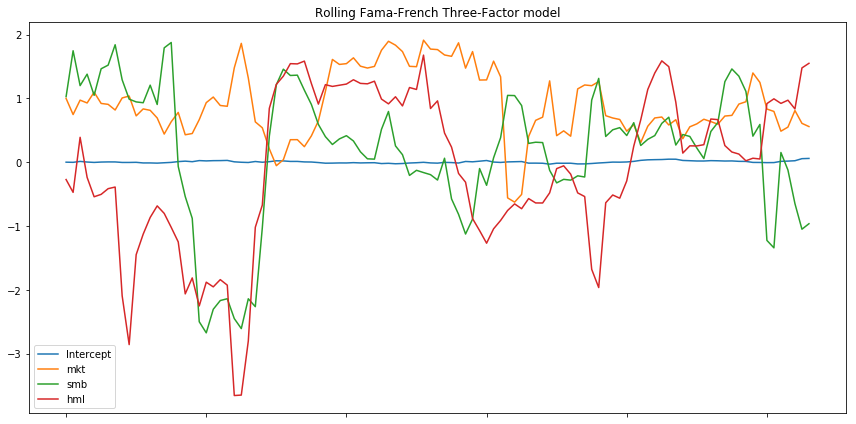

In [39]:
MODEL_FORMULA = 'ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=12)
results_df.plot(title = 'Rolling Fama-French Three-Factor model', figsize=(12,6))

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

In [42]:
results_df.index = pd.to_datetime(results_df.index)

In [50]:
results_df.head()

,Intercept,mkt,smb,hml
2011-12-01,0.000819,0.999676,1.027964,-0.271446
2012-01-01,-0.001632,0.747546,1.747413,-0.472318
2012-02-01,0.012828,0.973274,1.200799,0.390423
2012-03-01,0.002968,0.928907,1.380199,-0.237413
2012-04-01,-0.002968,1.097687,1.048735,-0.541343


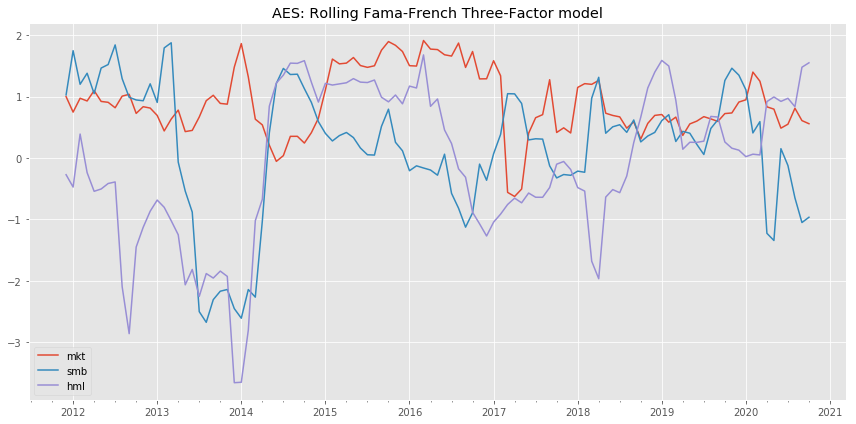

In [52]:
results_df[['mkt', 'smb', 'hml']].plot(title = 'AES: Rolling Fama-French Three-Factor model', figsize=(12,6))
plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

In [46]:
ff_model_1 = smf.ols(formula =' ex_rtn ~mkt + smb + hml', data = ff_data).fit()

In [48]:
print(ff_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 ex_rtn   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     18.79
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           5.71e-10
Time:                        15:23:18   Log-Likelihood:                 174.47
No. Observations:                 118   AIC:                            -340.9
Df Residuals:                     114   BIC:                            -329.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0029      0.006     -0.522      0.6

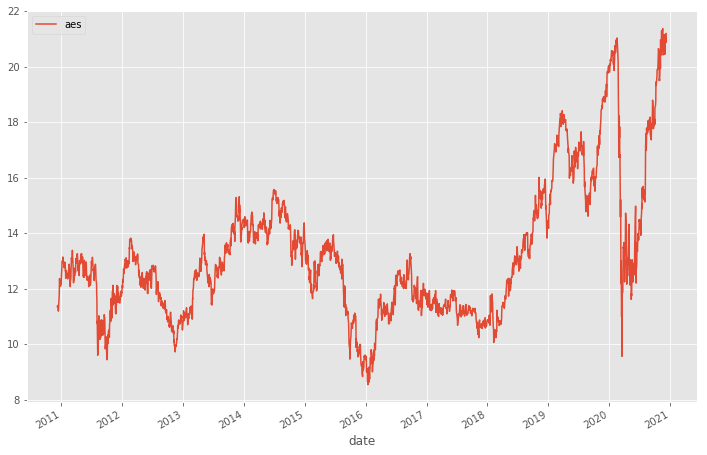

In [55]:
aes_df = pd.read_csv('Data/aes.csv', index_col=0, parse_dates = True)
aes_df.plot(figsize=(12,8))

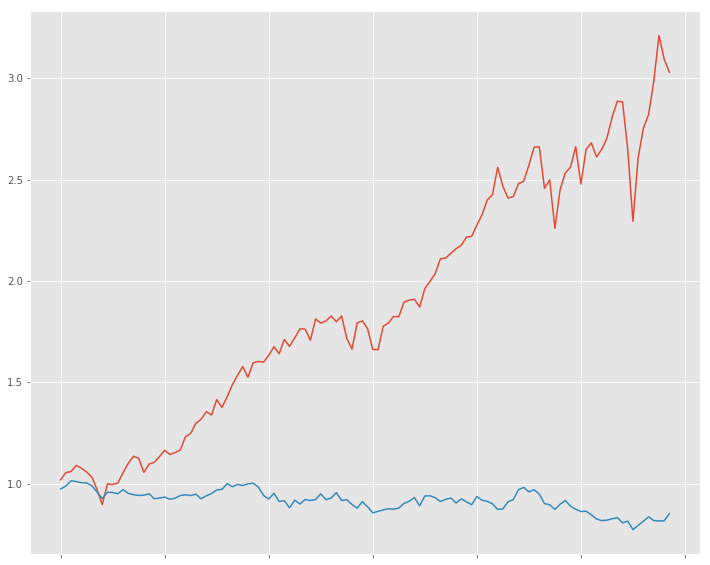

In [62]:
(1+ff_data['mkt']).cumprod().plot(figsize=(12,10))
(1+ff_data['smb']).cumprod().plot()
#(1+ff_data['hml']).cumprod().plot()